# Definindo sistema


In [1]:
import numpy as np
from scipy.integrate import solve_ivp


def q(t):
    if t < 100:
        return 10
    else:
        return 5


def edo(t, Y, c1, c2):
    # Constantes
    A1 = 1
    A2 = 1

    # Dependent variables
    h1, h2 = Y[0], Y[1]

    # Tanks limits
    h1 = np.where(h1 < 0.0, 0.0, h1)
    h2 = np.where(h2 < 0.0, 0.0, h2)

    # Equations
    dh1dt = (q(t) - c1 * np.sqrt(h1)) / A1
    dh2dt = (c1 * np.sqrt(h1) - c2 * np.sqrt(h2)) / A2
    return [dh1dt, dh2dt]


t = np.linspace(0, 300, 500)


def simulate(c1, c2):
    sol = solve_ivp(edo, [t[0], t[-1]], [0, 0], t_eval=t, method="RK45", args=(c1, c2))
    return sol.y


# Imprimindo dados experimentais


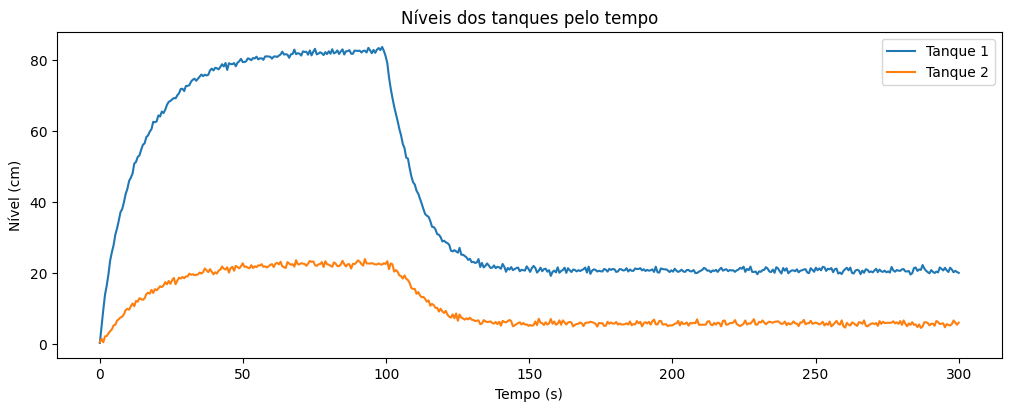

In [2]:
import matplotlib.pyplot as plt


def plot_tanks(t, tanks, labels=None):
    plt.figure(figsize=(10, 4), layout="constrained")
    plt.title("Níveis dos tanques pelo tempo")

    for i, tank in enumerate(tanks):
        label = labels[i] if (type(labels) is list) else labels
        plt.plot(t, tank, label=label)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Nível (cm)")
    plt.legend()
    plt.show()


h1_exp, h2_exp = simulate(1.1, 2.1)

# Gerando ruído
np.random.seed(42)
noise_h1 = np.random.normal(0, 0.5, size=h1_exp.shape)
noise_h2 = np.random.normal(0, 0.5, size=h2_exp.shape)
h1_exp = h1_exp + noise_h1
h2_exp = h2_exp + noise_h2


plot_tanks(t, [h1_exp, h2_exp], ["Tanque 1", "Tanque 2"])


# Definindo função objetivo


In [3]:
import concurrent.futures


def loss(C):
    c1, c2 = C
    h1_sim, h2_sim = simulate(c1, c2)
    total_loss = np.mean(np.square(h1_exp - h1_sim)) + np.mean(
        np.square(h2_exp - h2_sim)
    )

    # print(f"c1: {c1}, c2: {c2}, loss: {total_loss}")
    return total_loss


# Otimizando pelo Scipy
# from scipy.optimize import minimize
# bounds = [(0, None), (0, None)]
# result = minimize(loss, [0,0], method='Powell', bounds=bounds)

# Visualizando a função objetivo
c1_vals = np.linspace(0, 5, 200)  # Intervalo de valores para c1
c2_vals = np.linspace(0, 5, 200)  # Intervalo de valores para c2
C1, C2 = np.meshgrid(c1_vals, c2_vals)

# Calculando em paralelo os valores para maior velocidade
combinations = [
    (C1[i, j], C2[i, j]) for i in range(C1.shape[0]) for j in range(C1.shape[1])
]
Z = np.zeros_like(C1)

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(loss, combinations))

for idx, result in enumerate(results):
    i, j = divmod(idx, C1.shape[1])
    Z[i, j] = result


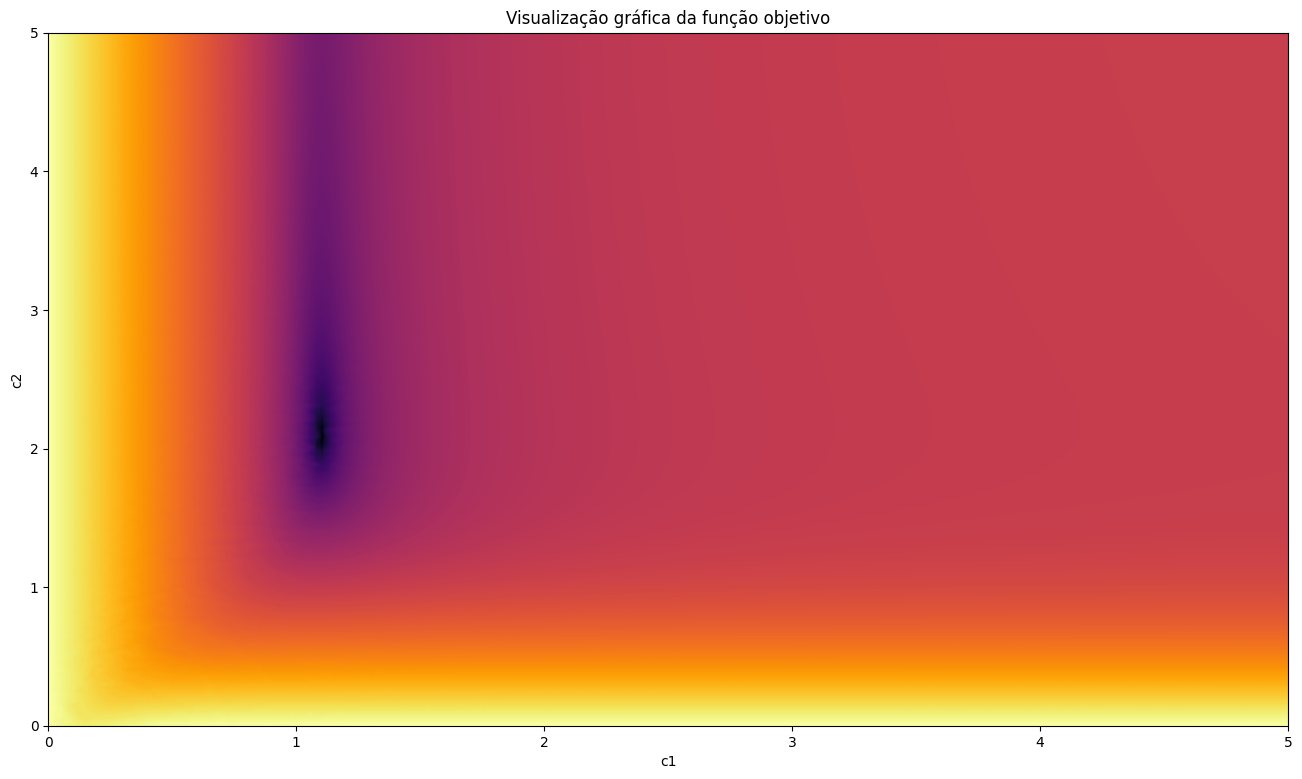

In [4]:
import matplotlib.colors as mcolors

# Plotando o gráfico
plt.figure(figsize=(16, 9))
plt.contourf(
    C1,
    C2,
    Z,
    levels=np.logspace(0, np.log10(np.max(Z)), 1000),
    cmap="inferno",
    norm=mcolors.LogNorm(vmin=1, vmax=np.max(Z), clip=True),
)
# plt.colorbar()
plt.xlabel("c1")
plt.ylabel("c2")
plt.title("Visualização gráfica da função objetivo")
plt.show()


# Implementação do algorítimo genético clássico


In [5]:
import numpy as np


# Função objetivo (exemplo simples: uma função quadrática com um mínimo global)
def objective_function(x, y):
    return (x - 3) ** 2 + (y - 2) ** 2


# Função de avaliação do fitness (quanto menor o valor da função, melhor)
def fitness(individual):
    x, y = individual
    return -objective_function(x, y)  # Negativo porque estamos minimizando


# Inicializa a população com indivíduos aleatórios
def initialize_population(pop_size, bounds):
    population = []
    for _ in range(pop_size):
        x = np.random.uniform(bounds[0][0], bounds[0][1])
        y = np.random.uniform(bounds[1][0], bounds[1][1])
        population.append([x, y])
    return np.array(population)


# Seleção de pais por torneio
def tournament_selection(population, fitnesses, k=3):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmax(fitnesses[selected])]
    return population[best]


# Cruzamento (Crossover) simples
def crossover(parent1, parent2, crossover_rate=0.8):
    if np.random.rand() < crossover_rate:
        alpha = np.random.rand()  # Peso para a combinação linear
        child1 = alpha * parent1 + (1 - alpha) * parent2
        child2 = alpha * parent2 + (1 - alpha) * parent1
        return child1, child2
    else:
        return parent1, parent2


# Mutação simples (perturbação em uma variável)
def mutate(individual, mutation_rate=0.1, mutation_strength=0.1):
    if np.random.rand() < mutation_rate:
        idx = np.random.randint(0, 2)  # Escolhe entre x ou y para mutar
        individual[idx] += np.random.uniform(-mutation_strength, mutation_strength)
    return individual


# Algoritmo Genético
def genetic_algorithm(
    pop_size, bounds, generations, crossover_rate=0.8, mutation_rate=0.1
):
    # Inicializar a população
    population = initialize_population(pop_size, bounds)
    best_solution = None
    best_fitness = -np.inf

    for generation in range(generations):
        # Avaliar o fitness de cada indivíduo
        fitnesses = np.array([fitness(ind) for ind in population])

        # Atualizar o melhor indivíduo
        current_best_idx = np.argmax(fitnesses)
        current_best_fitness = fitnesses[current_best_idx]
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[current_best_idx]

        # Nova população
        new_population = []

        while len(new_population) < pop_size:
            # Selecionar pais
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            # Realizar crossover
            child1, child2 = crossover(parent1, parent2, crossover_rate)

            # Realizar mutação
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            # Adicionar filhos à nova população
            new_population.append(child1)
            if len(new_population) < pop_size:
                new_population.append(child2)

        population = np.array(new_population)

        print(
            f"Geração {generation + 1}: Melhor solução = {best_solution}, Melhor fitness = {-best_fitness}"
        )

    return best_solution, -best_fitness


# Definir os parâmetros do algoritmo
pop_size = 50
bounds = [(-10, 10), (-10, 10)]  # Limites para x e y
generations = 100

# Executar o algoritmo genético
best_solution, best_fitness = genetic_algorithm(pop_size, bounds, generations)

print(f"Melhor solução encontrada: {best_solution}")
print(f"Valor da função objetivo na melhor solução: {best_fitness}")


Geração 1: Melhor solução = [2.45933167 2.6312044 ], Melhor fitness = 0.690741238607399
Geração 2: Melhor solução = [2.69573263 1.89371214], Melhor fitness = 0.1038757426332171
Geração 3: Melhor solução = [2.78750458 2.24027869], Melhor fitness = 0.10288815474050272
Geração 4: Melhor solução = [2.88750519 1.89993063], Melhor fitness = 0.022668960613981992
Geração 5: Melhor solução = [2.88750519 1.97872858], Melhor fitness = 0.013107556029519792
Geração 6: Melhor solução = [2.88750519 1.97872858], Melhor fitness = 0.013107556029519792
Geração 7: Melhor solução = [2.88750519 1.97872858], Melhor fitness = 0.013107556029519792
Geração 8: Melhor solução = [2.93299985 2.02221835], Melhor fitness = 0.0049826743618344846
Geração 9: Melhor solução = [2.93299985 2.02221835], Melhor fitness = 0.0049826743618344846
Geração 10: Melhor solução = [2.93299985 2.02221835], Melhor fitness = 0.0049826743618344846
Geração 11: Melhor solução = [2.93299985 2.02221835], Melhor fitness = 0.0049826743618344846